# All results on Synthetic datasets - Prob. images

Presenting results all state-of-the-art methods togehter with our APDL method

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import pandas, numpy
from skimage import io
import matplotlib.pylab as plt
from matplotlib import gridspec
import apdl.dataset_utils as gen_data
from notebooks.notebook_utils import filter_df_results_4_plotting, plot_apdl_graph_results

In [2]:
# p_csv = os.path.expanduser('~/Dropbox/Documents/lab_CMP-BIA/paper_2017_drosophila_APDL/data/experiments_synth_APD_prob_results_NEW_OVERALL.csv')
p_csv = os.path.expanduser(os.path.join('results', 'experiments_synth_APD_prob_results_NEW_OVERALL.csv'))
print os.path.exists(p_csv), '<-', p_csv
# DATASET = 'datasetProb_raw'
# p_data = '/mnt/F464B42264B3E590/TEMP/atomicPatternDictionary_v0'
# print os.path.exists(p_data), '<-', p_data

True <- results/experiments_synth_APD_prob_results_NEW_OVERALL.csv


## Loading data

In [5]:
df_all = pandas.DataFrame().from_csv(p_csv, index_col=None)
df_all.dropna(subset=['nb_labels', 'atlas_ARS', 'reconstruct_diff'], inplace=True)
print '-> loaded DF with', len(df_all), 'items and columns:\n', df_all.columns.tolist()
d_unique = {col: df_all[col].unique() for col in df_all.columns}
df_all.sort_values('nb_labels', inplace=True)
print '-> unique:', {k: len(d_unique[k]) for k in d_unique if len(d_unique[k]) > 1}

-> loaded DF with 24357 items and columns:
['nb_labels', 'atlas ARS', 'atlas accuracy', 'atlas f1_macro', 'atlas f1_weighted', 'atlas precision_macro', 'atlas precision_weighted', 'atlas recall_macro', 'atlas recall_weighted', 'atlas support_macro', 'atlas support_weighted', 'atlas_ARS', 'reconstruct_diff', 'time', 'folders', 'max_iter', 'path_out', 'dataset', 'computer', 'path_exp', 'files @dir', 'class', 'nb_runs', 'name', 'overlap_mj', 'gc_reinit', 'ptn_compact', 'nb_jobs', 'nb_samples', 'ptn_split', 'gc_regul', 'tol', 'path_in', 'type', 'method', 'init_tp']
-> unique: {'atlas ARS': 14682, 'atlas f1_weighted': 13931, 'atlas accuracy': 6005, 'atlas recall_macro': 14688, 'name': 56, 'nb_labels': 29, 'nb_jobs': 4, 'atlas_ARS': 14682, 'class': 10, 'atlas precision_weighted': 6005, 'dataset': 14, 'atlas precision_macro': 13411, 'computer': 3, 'path_exp': 5811, 'time': 24356, 'reconstruct_diff': 9149, 'method': 5, 'path_in': 4, 'atlas recall_weighted': 14685, 'nb_runs': 2, 'atlas f1_macro

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if __name__ == '__main__':


## Parse name and noise level

In [6]:
df_all['version'] = map(os.path.basename, df_all['path_in'])
print 'Versions:', df_all['version'].unique().tolist()

Versions: ['atomicPatternDictionary_00', 'atomicPatternDictionary_v0', 'atomicPatternDictionary_v1', 'atomicPatternDictionary_v2']


Versions: ['atomicPatternDictionary_00', 'atomicPatternDictionary_v0', 'atomicPatternDictionary_v1', 'atomicPatternDictionary_v2']


In [7]:
print 'Datasets:', df_all['dataset'].unique().tolist()

Datasets: ['datasetProb_noise', 'datasetProb_defNoise', 'datasetProb_deform', 'datasetProb_raw', 'datasetProb_raw_gauss-0.100', 'datasetProb_raw_gauss-0.001', 'datasetProb_raw_gauss-0.200', 'datasetProb_raw_gauss-0.150', 'datasetProb_raw_gauss-0.075', 'datasetProb_raw_gauss-0.025', 'datasetProb_raw_gauss-0.050', 'datasetProb_raw_gauss-0.010', 'datasetProb_raw_gauss-0.005', 'datasetProb_raw_gauss-0.125']


Datasets: ['datasetProb_noise', 'datasetProb_defNoise', 'datasetProb_deform', 'datasetProb_raw', 'datasetProb_raw_gauss-0.100', 'datasetProb_raw_gauss-0.001', 'datasetProb_raw_gauss-0.200', 'datasetProb_raw_gauss-0.150', 'datasetProb_raw_gauss-0.075', 'datasetProb_raw_gauss-0.025', 'datasetProb_raw_gauss-0.050', 'datasetProb_raw_gauss-0.010', 'datasetProb_raw_gauss-0.005', 'datasetProb_raw_gauss-0.125']


In [8]:
noise, dataset_name = [], []
for d in df_all['dataset'].values.tolist():
    if '-' in d:
        noise.append(float(d.split('-')[-1]))
        dataset_name.append(d.split('-')[0])
    else: 
        noise.append(None)
        dataset_name.append(d)
df_all['dataset'] = dataset_name
df_all['noise'] = noise
print 'Datasets:', df_all['dataset'].unique().tolist()
print 'Noise levels:', df_all['noise'].unique().tolist()

Datasets: ['datasetProb_noise', 'datasetProb_defNoise', 'datasetProb_deform', 'datasetProb_raw', 'datasetProb_raw_gauss']
Noise levels: [nan, 0.1, 0.001, 0.2, 0.15, 0.075, 0.025, 0.05, 0.01, 0.005, 0.125]


Datasets: ['datasetProb_noise', 'datasetProb_defNoise', 'datasetProb_deform', 'datasetProb_raw', 'datasetProb_raw_gauss']
Noise levels: [nan, 0.1, 0.001, 0.2, 0.15, 0.075, 0.025, 0.05, 0.01, 0.005, 0.125]


## Dependency on iter. parameter

take out the series with various param combination

In [9]:
# LIST_GRAPHS = ['atlas ARS', 'atlas accuracy', 'atlas f1_weighted', 'atlas precision_weighted', 'atlas recall_weighted', 'reconstruct_diff', 'time']
LIST_GRAPHS = ['atlas ARS', 'atlas f1_weighted', 'reconstruct_diff', 'time']

## Dependency on number of samples

{'atomicPatternDictionary_00': {'NMF': [1, 2, 1], 'DL': [1, 2, 1], 'PCA': [1, 2, 1], 'ICA': [1, 2, 1], 'APDL': [1, 2, 1]}, 'atomicPatternDictionary_v2': {'NMF': [78, 78, 78, 78, 78, 78, 78, 80, 80, 78, 78, 78, 78, 78, 78, 78], 'DL': [75, 75, 75, 75, 75, 75, 75, 76, 76, 75, 75, 75, 75, 75, 75, 75], 'PCA': [76, 76, 76, 76, 76, 76, 76, 78, 78, 76, 76, 76, 76, 76, 76, 76], 'ICA': [76, 76, 76, 76, 76, 76, 76, 78, 78, 76, 76, 76, 76, 76, 76, 76], 'APDL': [75, 75, 75, 75, 75, 75, 75, 76, 76, 75, 75, 75, 75, 75, 75, 75]}, 'atomicPatternDictionary_v0': {'NMF': [78, 78, 78, 80, 80, 78, 78], 'DL': [78, 78, 78, 80, 80, 78, 78], 'PCA': [78, 78, 78, 80, 80, 78, 78], 'ICA': [78, 78, 78, 80, 80, 78, 78], 'APDL': [78, 78, 78, 80, 80, 78, 78]}, 'atomicPatternDictionary_v1': {'NMF': [78, 78, 78, 78, 78, 78, 78, 78, 80, 80, 78, 78, 78, 78, 78], 'DL': [78, 78, 78, 78, 78, 78, 78, 78, 80, 80, 78, 78, 78, 78, 78], 'PCA': [78, 78, 78, 78, 78, 78, 78, 78, 80, 80, 78, 78, 78, 78, 78], 'ICA': [78, 78, 78, 78, 78

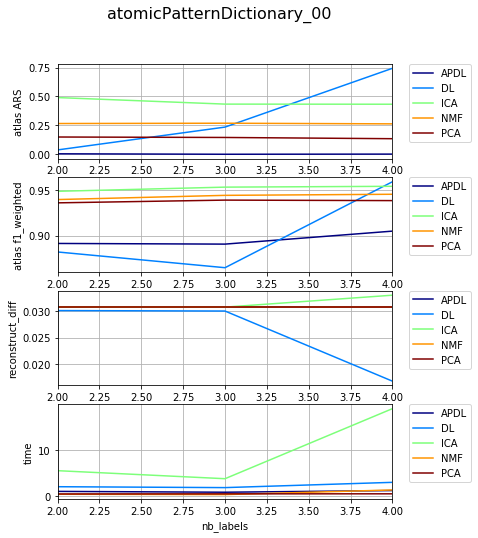

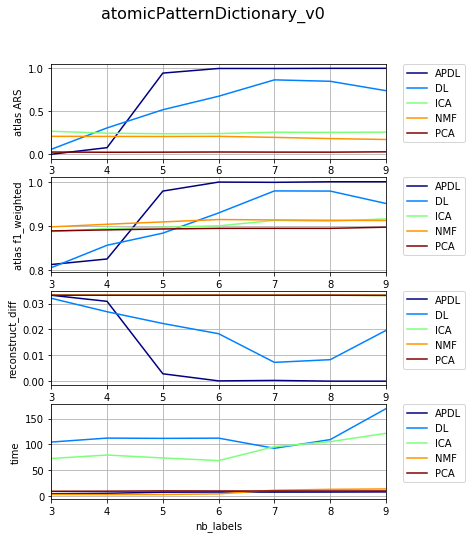

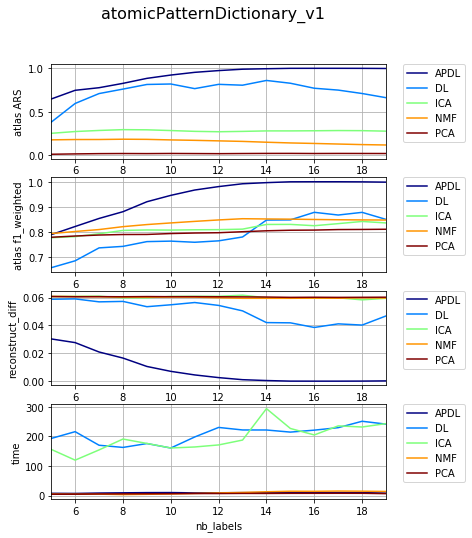

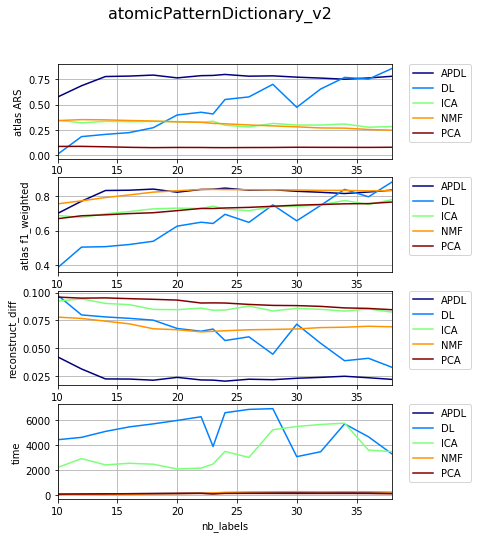

In [13]:
df_select = df_all[df_all['dataset'] == 'datasetProb_raw']
df_res, dict_samples = filter_df_results_4_plotting(df_select, n_group='version', n_class='method', iter_var='nb_labels', cols=LIST_GRAPHS)
print dict_samples
plot_apdl_graph_results(df_res, 'version', 'method', l_graphs=LIST_GRAPHS, iter_var='nb_labels', figsize=(6, 2))

## Dependency on level of noise

{'atomicPatternDictionary_v0': {'NMF': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'DL': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'PCA': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'ICA': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'APDL': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}}


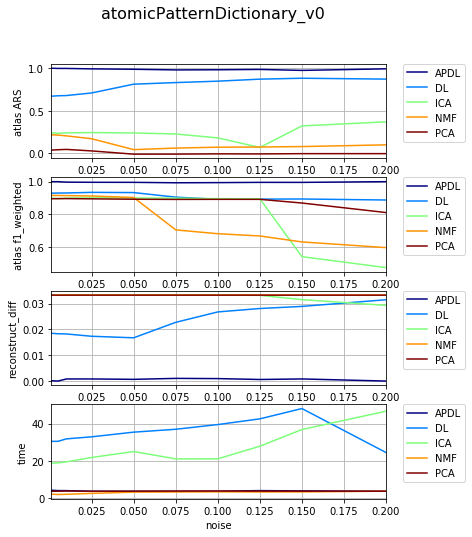

In [14]:
df_select = df_all[df_all['dataset'] == 'datasetProb_raw_gauss']
df_select = df_select[df_select['version'] == 'atomicPatternDictionary_v0']
df_select = df_select[df_select['nb_labels'] == 6]
df_res, dict_samples = filter_df_results_4_plotting(df_select, n_group='version', n_class='method', iter_var='noise', cols=LIST_GRAPHS)
print dict_samples
plot_apdl_graph_results(df_res, 'version', 'method', l_graphs=LIST_GRAPHS, iter_var='noise', figsize=(6, 2))

{'atomicPatternDictionary_v1': {'NMF': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'DL': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'PCA': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'ICA': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'APDL': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}}


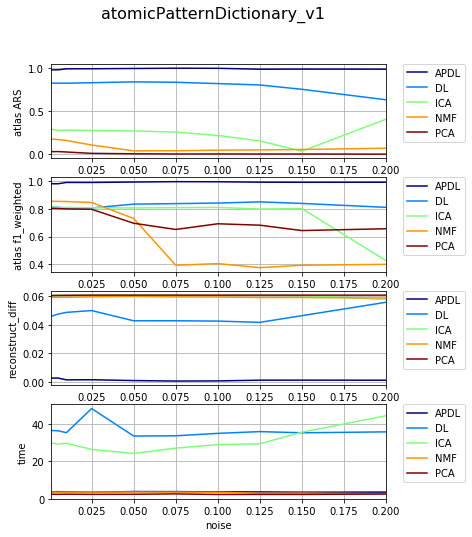

In [15]:
df_select = df_all[df_all['dataset'] == 'datasetProb_raw_gauss']
df_select = df_select[df_select['version'] == 'atomicPatternDictionary_v1']
df_select = df_select[df_select['nb_labels'] == 13]
df_res, dict_samples = filter_df_results_4_plotting(df_select, n_group='version', n_class='method', iter_var='noise', cols=LIST_GRAPHS)
print dict_samples
plot_apdl_graph_results(df_res, 'version', 'method', l_graphs=LIST_GRAPHS, iter_var='noise', figsize=(6, 2))

{'atomicPatternDictionary_v2': {'NMF': [30, 30, 30, 30, 30, 30, 30, 30, 30, 30], 'DL': [29, 29, 29, 29, 29, 29, 29, 29, 29, 29], 'PCA': [29, 29, 29, 29, 29, 29, 29, 29, 29, 29], 'ICA': [30, 30, 30, 29, 29, 29, 29, 29, 29, 29], 'APDL': [28, 28, 28, 28, 28, 28, 28, 28, 28, 28]}}


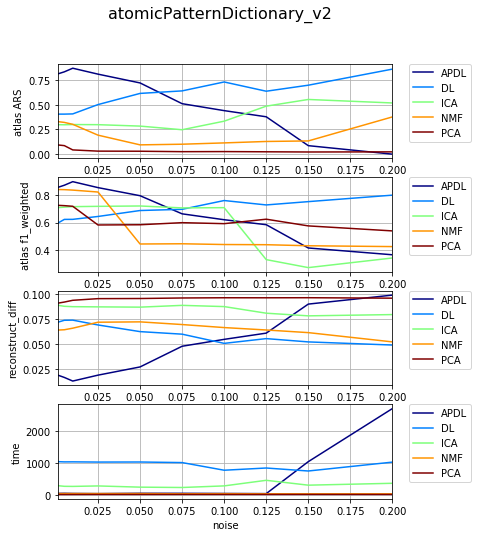

In [17]:
df_select = df_all[df_all['dataset'] == 'datasetProb_raw_gauss']
df_select = df_select[df_select['version'] == 'atomicPatternDictionary_v2']
df_select = df_select[df_select['nb_labels'] == 23]
df_res, dict_samples = filter_df_results_4_plotting(df_select, n_group='version', n_class='method', iter_var='noise', cols=LIST_GRAPHS)
print dict_samples
plot_apdl_graph_results(df_res, 'version', 'method', l_graphs=LIST_GRAPHS, iter_var='noise', figsize=(6, 2))